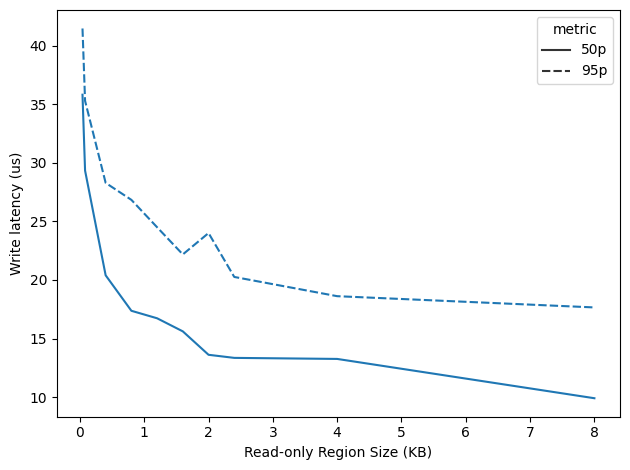

In [1]:
# writes

import sys
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_flush_interval(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [HybridLog], [{
        'max_runs_per_level': [3],
        'ro_lag_interval': [1_000],
        'flush_interval': [5, 10, 50, 100, 150, 200, 250, 300, 500, 1000],
        'hash_index': ['dict'],
        'remote': [None]
    }],
    [measure_flush_interval], {}
)


data = df[['flush_interval', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000 # us
data['flush_interval'] = data['flush_interval'] * (4+4) / 1000

lineplot(data=data, x='flush_interval', y='value', style='metric',
         filename='flush_interval_write.pdf', xlabel='Read-only Region Size (KB)',
         ylabel='Write latency (us)')


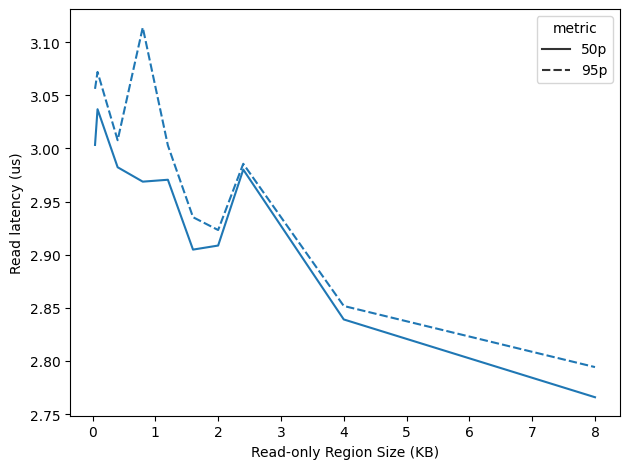

In [3]:
# reads


from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_flush_interval(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_sec = 10_000
    
    # populate first
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(reads_per_sec):
                _ = db[keys_set[next(distro)]]
        latency = float(latency)
        avg_latency = latency / reads_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [HybridLog], [{
        'max_runs_per_level': [3],
        'ro_lag_interval': [1_000],
        'flush_interval': [5, 10, 50, 100, 150, 200, 250, 300, 500, 1000],
        'hash_index': ['dict'],
        'remote': [None]
    }],
    [measure_flush_interval], {}
)


data = df[['flush_interval', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000 # us
data['flush_interval'] = data['flush_interval'] * (4+4) / 1000


lineplot(data=data, x='flush_interval', y='value', style='metric',
         filename='flush_interval_read.pdf', xlabel='Read-only Region Size (KB)',
         ylabel='Read latency (us)')